In [11]:
import numpy as np
import matplotlib.pyplot as pl
import projection
import numpy as np
import scipy.special as sp
import scipy.linalg as spla
import scipy.sparse as sparse
import scipy.integrate as integ
import matplotlib.pyplot as pl
import pyiacsun as ps
import seaborn as sns
import uuid
import glob
import wavefront as wf
%matplotlib inline

In [16]:
from IPython.display import SVG
def show_svg(file):
    return SVG(file)

Fluctuations in the refraction index of the atmosphere affects the propagation of light and produces what astronomers know as *seeing*. Under the geometric optics approximation, the phase of light $\phi$ at a given aperture is given by the integration of the phase perturbation along the whole atmosphere of height $H$:

$$
\phi(\mathbf{r},\boldsymbol{\theta}) = \int_0^H \phi(\mathbf{r}+h \boldsymbol{\theta}_k) \mathrm{d}h,
$$

where $\boldsymbol{\theta}$ indicates the direction at which we are observing and $\mathbf{r}$ is the vector position of a position in the telescope aperture. Assuming that there is a finite number $K$ of infinitely thin turbulence layers in the atmosphere, the previous integral can be written as a summation:

$$
\phi(\mathbf{r},\boldsymbol{\theta}) \approx \sum_{i=1}^K \phi_i(\mathbf{r}+h_i \boldsymbol{\theta}_k).
$$

The following figure displays the projection of the telescope entrance pupil on different layers in the atmosphere. It can be seen that these projections occupy only a portion of the field-of-view of the telescope or metapupil.

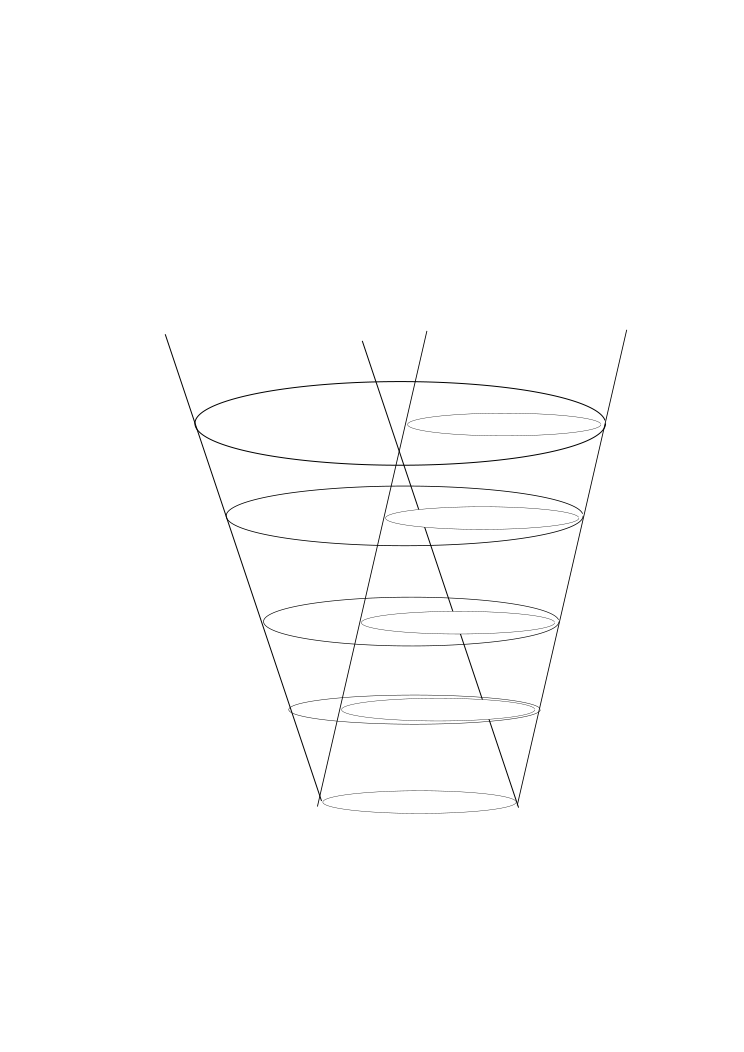

In [17]:
show_svg('metapupil.svg')

It was demonstrated by Ragazzoni et al. (1999) that if the phase in a given metapupil is written as a linear combination of Zernike functions as

$$
\phi_i(\mathrm{r}) = \sum_{k=1}^N \alpha_{ik} Z_k(\mathrm{r}),
$$

then the Zernike expansion of any circular part of the metapupil can be written again as a linear combination of Zernike functions, with the same upper $N$:

$$
\phi'_i(\mathrm{r}') = \sum_{k=1}^N \beta_{ik} Z_k(\mathrm{r}'),
$$

This means that both expansion coefficients can be related with a matrix, whose matrix elements can be obtained analytically or numerically by projection (e.g., Tatulli 2013):

$$
\boldsymbol{\beta} = \mathbf{M} \boldsymbol{\alpha}
$$

Given the previous relations, assume that we measure the wavefront towards a set of $M$ stars. Each wavefront is then projected over the Zernike orthogonal basis, so that each star $k$ provides an equation like:

$$
\phi_k = \sum_{i=1}^K \beta_{ik} Z_i(\mathrm{r}) = \sum_{i=1}^K \phi_i(\mathbf{r}+h_i \boldsymbol{\theta}_k) = \sum_{i=1}^K \sum_{k=1}^N \alpha_{ik} Z_k(\mathrm{r})
$$

If now we stack together all wavefronts observed for each star, we can write a linear system like:

$$
\left[ 
\begin{array}{c}
b_1^\mathrm{star\, 1} \\
b_2^\mathrm{star\, 1} \\
\vdots \\
b_1^\mathrm{star\, 2} \\
b_2^\mathrm{star\, 2} \\
\vdots \\
b_1^\mathrm{star\, K} \\
b_2^\mathrm{star\, K} \\
\end{array}
\right] = \left[
\begin{array}{cccc}
\left[ \mathbf{M}_\mathrm{h1}^\mathrm{star\, 1}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star\, 1}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star\, 1}\right] & \cdots \\
\left[ \mathbf{M}_\mathrm{h1}^\mathrm{star\, 1}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star\, 1}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star\, 1}\right] & \cdots \\
\cdots & \cdots & \cdots & \cdots \\
\left[ \mathbf{M}_\mathrm{h1}^\mathrm{star K}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star K}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star K}\right] & \cdots 
\end{array}
\right]
\left[
\begin{array}{c}
a_1^\mathrm{h1} \\
a_2^\mathrm{h1} \\
\vdots \\
a_1^\mathrm{h2} \\
a_2^\mathrm{h2} \\
\vdots \\
a_1^\mathrm{hK} \\
a_2^\mathrm{hK} \\
\end{array}
\right]
$$

where $a_i^\mathrm{hK}$ is the $i$-th Zernike coefficient of the expansion of the phase perturbation at height $K$, while $b_i^\mathrm{star\, K}$ is the measured $i$-th Zernike coefficient of the wavefront towards star $K$. The linear system matrix has dimensions $N_Z N_S \times N_Z N_H$, with $N_S$ the number of stars, $N_Z$ the number of Zernike coefficients to consider and $N_H$ the number of considered layers.

### Least-squares solution
In order to end up with a well-determined linear system, the number of layers to considered has to be equal or smaller than the number of stars observed. The linear system is usually solved in the least-squares sense because noise can produce that the linear system has no definite solution. Once the number of layers is fixed, from all the potential solutions, we pick up the one that minimizes the $\ell_2$ norm:

$$
\Vert \mathbf{M} \boldsymbol{\alpha} - \boldsymbol{\beta} \Vert^2,
$$
which is given by the pseudo-inverse

$$
\boldsymbol{\alpha} = \left( \mathbf{M}^T \mathbf{M} \right)^{-1} \mathbf{M} \boldsymbol{\beta}
$$

or 

$$
\boldsymbol{\alpha} = \left( \mathbf{M}^T \mathbf{M} + \boldsymbol{\Sigma}^T \boldsymbol{\Sigma} \right)^{-1} \mathbf{M} \boldsymbol{\beta}
$$

if one wants to regularize the solution by imposing some covariance between the $\boldsymbol{\alpha}$ coefficients, where $\boldsymbol{\Sigma}$ is the inverse covariance matrix (that can be, for instance, the expected covariance matrix for the Zernike coefficients under a certain model for turbulence).

### Sparsity regularization
It is worth exploring the application of sparsity regularization techniques. The idea to exploit (and that is used in all current tomography methods) is that the effect of the atmosphere can be efficiently assumed to be concentrated on a few layers. Therefore, if the maximum number of heights is $N_\mathrm{max}$, only $N \ll N_\mathrm{max}$ are *active*. Therefore, it makes sense to solve the problem

$$
\Vert \mathbf{M} \boldsymbol{\alpha} - \boldsymbol{\beta} \Vert^2 + \lambda \Vert \boldsymbol{\alpha} \Vert_0,
$$

where the $\Vert \mathbf{x} \Vert_0$ is the number of non-zero coefficients of the vector $\mathbf{x}$. In our case, the $\ell_0$ norm has to be taken in the height dimension, not in the number of Zernike coefficients. The previous problem is known to be NP-complete and difficult to solve. However, Cand\`es et al. (2006) demonstrated that the same solution can be obtained in very general conditions if the problem is substituted by the much simpler to solve

$$
\Vert \mathbf{M} \boldsymbol{\alpha} - \boldsymbol{\beta} \Vert^2 + \lambda \Vert \boldsymbol{\alpha} \Vert_1,
$$

where the $\Vert \mathbf{x} \Vert_1$ is the sum of the absolute value of the elements of the vector $\mathbf{x}$.

A very successul set of iterative methods to solve this kind of problems are the proximal algorithms, in which a standard optimization scheme is augmented with a proximal projection operator (a proximal projection operator projects the current solution on a subspace that fulfills the imposed constraints). One of the simplest and most successful algorithms is the fast iterative shriknkage-thresholding algorithm (FISTA; Beck & Teboulle 2009), which is:

  1. Initialization: $t_0=1$, $\boldsymbol{\alpha}_1=0$, $\tau < 2 / \Vert \mathbf{M} \Vert_S$, $\lambda$
  2. Update values: $\boldsymbol{\alpha}'_{i+1} = \boldsymbol{\alpha}_i - \tau \mathbf{M}^T (\boldsymbol{\beta}-\mathbf{M} \boldsymbol{\alpha}_i)$
  3. Apply proximal projection: $\boldsymbol{\alpha}_{i+1}=\mathrm{prox}_{\lambda,\tau}(\boldsymbol{\alpha}'_{i+1})$
  4. Update weight: $t_{i+1}= \frac{1+\sqrt{1+4t_i^2}}{2}$
  5. Update solution: $\boldsymbol{\alpha}_{i+1} = \boldsymbol{\alpha}_{i} + \left( \frac{t_i-1}{t_{i+1}} \right) (\boldsymbol{\alpha}_{i+1} - \boldsymbol{\alpha}_{i})$
  6. Go to 2 if not converged
  
where $\Vert \mathbf{M} \Vert_S$ is the spectral norm of the matrix $\mathbf{M}$.

The proximal projection $\mathrm{prox}_{\lambda,\tau}(x)$ operator associated with the $\ell_1$ regularization function is given by the soft thresholding operator:

$$
\mathrm{prox}_{\lambda,\tau}(\mathbf{x}) = \mathrm{sign}(\mathbf{x}) \left( |\mathbf{x}|-\tau \lambda \right)_+
$$

where $(\cdot)_+$ denotes the positive part. The soft-thresholding operator is shown in the following for $\lambda=1$. It shows that the effect of the soft-thresholding is to put to zero all values of $\mathbf{x}<\lambda$ and damp the elements that are larger:

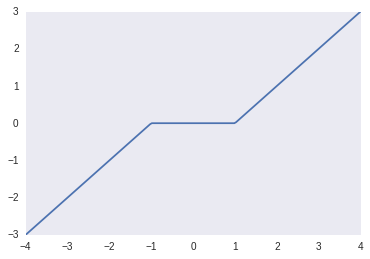

In [39]:
lambdaPar = 1.0
x = np.linspace(-4.0,4.0,200)
y = np.sign(x) * np.fmax(np.abs(x) - lambdaPar, 0)
pl.plot(x,y)

The coefficients $\boldsymbol{\alpha}$ can be understood as a set of $N_H$ vectors with dimension $N_Z$, because we have all the Zernike coefficients for all the heights. We know that, if a layer is active, it will contain all Zernike coefficients, because they are somehow organized by energy. Therefore, we see two different options for applying the proximal algorithm:

  1. We do not impose any restriction on the coefficients of each layer but regularize the number of active layers. This can be done by computing the power associated to each layer:
  $$
  E_j = \sum_{i=1}^{N_Z} \alpha_i(h_j)^2
  $$
  Then, the proximal operator is applied to these energies, and the ensuing reduction coefficient is applied as a whole to all the Zernike coefficients of each layer.
  
  2. We additionally impose a restriction on the coefficients, so that another proximal projection is applied for each height. This might help in noisy cases. 

### Example
We define in the following a Python class that solves the previous problem, both using the least-squares approach and also the sparse optimization.

In [33]:
def even(x):
    return x%2 == 0

class tomography(object):
    """This class defines an atmosphere that can be used to generate synthetic MCAO observations
    and also apply different tomography schemes
    """
    def __init__(self, nStars, nZernike, fov, heights, DTel, wavelength=5000., verbose=True, numericalProjection=True, addPiston=False):
        """Class creation
        
        Args:
            nStars (int): number of stars used for the MCAO
            nZernike (int): maximum number of Zernike coefficients to use
            fov (float): field-of-view [arcsec]
            heights (float): array of heights to be used [km]
            DTel (float): telescope diameter [m]
            verbose (bool, optional): turn on verbosity
            numericalProjection (bool, optional): use the numerical approach for computing the projection matrix for the footprints
            addPiston (bool, optional): add piston mode
        """
        self.nHeight = len(heights)
        self.nStars = nStars
        self.nZernike = nZernike
        self.fov = fov / 206265.0        # in radians
        self.heights = heights * 1e3
        self.DTel = DTel
        self.verbose = verbose
        self.MComputed = False
        self.numericalProjection = numericalProjection
        self.addPiston = addPiston
        self.noll0 = 1
        self.wavelength = wavelength

        if (not self.addPiston):
            self.noll0 = 2

        self.DMetapupil = self.DTel + self.heights * self.fov

        self.t = np.zeros((self.nHeight,self.nStars))
        self.beta = np.zeros((self.nHeight,self.nStars))
        self.angle = np.zeros((self.nHeight,self.nStars))

        if (self.verbose):
            print("-------------------------------------------------------------------")
            print(" - Zernike modes: {0}".format(self.nZernike))
            print(" - Number of heights : {0} -> {1} km".format(self.nHeight, self.heights * 1e-3))
            print(" - FOV: {0} arcsec".format(206265.*self.fov))
            print(" - Number of stars : {0}".format(self.nStars))
            print("-------------------------------------------------------------------")

        for i in range(self.nHeight):            
            for j in range(self.nStars-1):
                self.t[i,j] = (self.heights[i] * self.fov) / self.DMetapupil[i]
                self.beta[i,j] = self.DMetapupil[i] / self.DTel
                self.angle[i,j] = j * 2.0 * np.pi / (self.nStars - 1.0)
            self.t[i,-1] = 0.0
            self.beta[i,-1] = self.DMetapupil[i] / self.DTel
            self.angle[i,-1] = 0.0
        
        if (self.projectionExists() == 0):
            if (self.verbose):
                print("Projection matrix does not exist")
            self.computeProjection()

        self.aStack = {}
        self.a = {}

# Read cn2 file
        cn2 = np.loadtxt('cn2.dat')

# Compute total r0 value in cm
        self.r0Reference = (0.423 * (2.0 * np.pi / (self.wavelength*1e-10))**2 * integ.trapz(cn2[:,1], x=cn2[:,0]))**(-3.0/5.0) * 1e2

        for i in range(len(self.heights)):
            indFrom = ps.util.nearest(cn2[:,0] - cn2[0,0], self.heights[i])
            indTo = ps.util.nearest(cn2[:,0] - cn2[0,0], self.heights[i]+500.0)+1
            # print(integ.trapz(cn2[indFrom:indTo,1], x=cn2[indFrom:indTo,0]) / integ.trapz(cn2[:,1], x=cn2[:,0]))
        # stop()

    def projectionExists(self):
        """Check whether a projection matrix exists
        
        Returns:
            bool: True/False
        """
        files = glob.glob('matrices/transformationMatrices*.npz')
        for f in files:
            out = np.load(f)
            heights = out['arr_1']
            nStars = out['arr_2']
            nZernike = out['arr_3']
            fov = out['arr_4']
            DTel = out['arr_5']
            ind = np.where(np.in1d(heights, self.heights))[0]
            if (len(ind) == self.nHeight):
                if (nStars == self.nStars and nZernike >= self.nZernike and 
                    fov == self.fov and DTel == self.DTel):
                    self.M = out['arr_0'][0:self.nZernike,0:self.nZernike,ind,:]
                    if (self.verbose):
                        print("Projection matrix exists : {0}".format(f))
                        print(" - Zernike modes: {0}".format(self.nZernike))
                        print(" - Number of heights : {0} -> {1} km".format(self.nHeight, self.heights * 1e-3))
                        print(" - FOV: {0} arcsec".format(206265.*self.fov))
                        print(" - Number of stars : {0}".format(self.nStars))
                        self.MComputed = True
                        self.stackProjection()
                    return True
                
        return False

    def plotPupils(self):
        """Plot the pupils
                
        """
        ncols = int(np.ceil(np.sqrt(self.nHeight)))
        nrows = int(np.ceil(self.nHeight / ncols))
        cmap = sns.color_palette(n_colors=self.nStars)
        pl.close('all')

        f, ax = pl.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols,2*nrows))
        ax = ax.flatten()
        for i in range(self.nHeight):
            radiusMetapupil = self.DMetapupil[i] / 2.0
            circle = pl.Circle((0,0), radiusMetapupil, fill=False, linewidth=2, axes=ax[i])
            ax[i].add_artist(circle)
            ax[i].set_xlim([-0.7*self.DMetapupil[i],0.7*self.DMetapupil[i]])
            ax[i].set_ylim([-0.7*self.DMetapupil[i],0.7*self.DMetapupil[i]])
            ax[i].set_title('h={0} km'.format(self.heights[i] / 1e3))
            for j in range(self.nStars):
                radiusCircle = radiusMetapupil / self.beta[i,j]
                xCircle = radiusMetapupil * self.t[i,j] * np.cos(self.angle[i,j])
                yCircle = radiusMetapupil * self.t[i,j] * np.sin(self.angle[i,j])
                circle = pl.Circle((xCircle,yCircle), radiusCircle, fill=False, axes=ax[i], linewidth=2, color=cmap[j])
                ax[i].add_artist(circle)

    def computeProjection(self):
        """Compute the projection matrix for the heights and number of stars defined
        
        Returns:
            None
        """
        if (not self.MComputed):
            self.M = np.zeros((self.nZernike,self.nZernike,self.nHeight,self.nStars))
            for i in range(self.nHeight):
                print("\n**********************\n")
                print("Height: {0}/{1}\n".format(i+1,self.nHeight))
                print("**********************\n")
                for j in range(self.nStars):
                    print("\n  - Star: {0}/{1}".format(j+1,self.nStars))
                    if (self.numericalProjection):
                        self.M[:,:,i,j] = projection.zernikeProjectionMatrixNumerical(self.nZernike, self.beta[i,j], self.t[i,j], self.angle[i,j], verbose=True, radius=128, includePiston=False)
                    else:
                        self.M[:,:,i,j] = projection.zernikeProjectionMatrix(self.nZernike, self.beta[i,j], self.t[i,j], self.angle[i,j], verbose=True, includePiston=False)
            np.savez('matrices/transformationMatrices_{0}.npz'.format(uuid.uuid4()), self.M, self.heights, self.nStars, self.nZernike, self.fov, self.DTel)
            self.stackProjection()

    def stackProjection(self):
        """Stack the projection matrix to take all heights into account
        
        Returns:
            None
        """
        self.MStack = np.zeros((self.nZernike*self.nStars, self.nZernike*self.nHeight))
        for i in range(self.nHeight):
            for j in range(self.nStars):
                left = i*self.nZernike
                right = (i+1)*self.nZernike
                up = j*self.nZernike
                down = (j+1)*self.nZernike
                self.MStack[up:down,left:right] = self.M[:,:,i,j]

    def generateTurbulentZernikesKolmogorov(self, r0, keepOnly=None):
        """Generate the covariance matrix for the Zernike coefficients for a given value of r0 using Kolmogorov statistics
        
        Args:
            r0 (float): Fried radius [m]
        
        Returns:
            None
        """
        self.covariance = np.zeros((self.nZernike,self.nZernike))
        for i in range(self.nZernike):
            ni, mi = wf.nollIndices(i+self.noll0)
            for j in range(self.nZernike):
                nj, mj = wf.nollIndices(j+self.noll0)
                if (even(i - j)):
                    if (mi == mj):
                        phase = (-1.0)**(0.5*(ni+nj-2*mi))
                        t1 = np.sqrt((ni+1)*(nj+1)) * np.pi**(8.0/3.0) * 0.0072 * (self.DTel / r0)**(5.0/3.0)
                        t2 = sp.gamma(14./3.0) * sp.gamma(0.5*(ni+nj-5.0/3.0))
                        t3 = sp.gamma(0.5*(ni-nj+17.0/3.0)) * sp.gamma(0.5*(nj-ni+17.0/3.0)) * sp.gamma(0.5*(ni+nj+23.0/3.0))
                        self.covariance[i,j] = phase * t1 * t2 / t3

        self.a['Original'] = np.random.multivariate_normal(np.zeros(self.nZernike), self.covariance, size=(self.nHeight)).T

# Keep only the heights that we want
        if (keepOnly != None):
            for i in range(self.nHeight):
                if (self.heights[i]/1e3 not in keepOnly):
                    self.a['Original'][:,i] = 0.0

        self.aStack['Original'] = self.a['Original'].T.flatten()


    def generateTurbulentZernikesVonKarman(self, r0, L0):
        """Generate the covariance matrix for the Zernike coefficients for a given value of r0 using von Karman statistics
        
        Args:
            r0 (float): Fried radius [m]
            L0 (float): outer scale [m]
        
        Returns:
            None
        """
        self.covariance = np.zeros((self.nZernike,self.nZernike))
        for i in range(self.nZernike):
            ni, mi = wf.nollIndices(i+self.noll0)
            for j in range(self.nZernike):
                nj, mj = wf.nollIndices(j+self.noll0)
                if (even(i - j)):
                    if (mi == mj):
                        phase = (-1.0)**(0.5*(ni+nj-2*mi))
                        t1 = np.sqrt((ni+1)*(nj+1)) * np.pi**(8.0/3.0) * 1.16 * (self.DTel / r0)**(5.0/3.0)

                        for k in range(50):
                            phase2 = (-1.0)**k / np.math.factorial(k) * (np.pi*self.DTel / L0)**(2.0*k+ni+nj-5.0/3.0)
                            t2 = sp.gamma(k+0.5*(3+ni+nj)) * sp.gamma(k+2+0.5*(ni+nj)) * sp.gamma(k+1+0.2*(ni+nj)) * sp.gamma(5./6.-k-0.5*(ni+nj))
                            t3 = sp.gamma(3+k+ni+nj) * sp.gamma(2+k+ni) * sp.gamma(2+k+nj)

                            phase3 = (np.pi*self.DTel / L0)**(2.0*k)
                            t4 = sp.gamma(0.5*(ni+nj)-5./6.-k) * sp.gamma(k+7./3.) * sp.gamma(k+17/6) * sp.gamma(k+11/6)
                            t5 = sp.gamma(0.5*(ni+nj)+23/6.+k) * sp.gamma(0.5*(ni-nj)+17/6.+k) * sp.gamma(0.5*(ni-nj)+17/6.+k)
                            self.covariance[i,j] += phase * t1 * (phase2 * t2/t3 + phase3 * t4/t5)

        self.a['Original'] = np.random.multivariate_normal(np.zeros(self.nZernike), self.covariance, size=(self.nHeight)).T        
        self.aStack['Original'] = self.a['Original'].T.flatten()

    def generateWFS(self):
        """Generate a WFS taking into account all heights
        
        Returns:
            float: array of Zernike coefficients measured in all WFS
        """
        return self.MStack @ self.aStack['Original']
        # self.bStack += np.random.normal(loc=0.0, scale=0.05, size=self.bStack.shape)


    def solveSVD(self, b, regularize=False):
        """Solve the tomography using SVD
        
        Args:
            b (TYPE): array of WFS measurements
            regularize (bool, optional): apply Tikhonov regularization using the covariance matrix of the Zernike coefficients
        
        Returns:
            None
        """
        if (regularize):
            invCov = np.linalg.inv(self.covariance)
            matrixList = [invCov for i in range(self.nHeight)]
            cov = spla.block_diag(*matrixList)
            AInv = np.linalg.inv(self.MStack.T@self.MStack + cov.T@cov)
        else:
            AInv = np.linalg.inv(self.MStack.T@self.MStack)

        x = AInv @ self.MStack.T @ b
        
        self.aStack['SVD'] = x
        self.a['SVD'] = self.aStack['SVD'].reshape((self.nHeight,self.nZernike)).T

    def _g(self, x):
        return self.mu * np.linalg.norm(x, 1)

    def _proxL0Height(self, x, t):
        coef = x.reshape((self.nHeight,self.nZernike))
        coefOut = np.copy(coef)
        which = int(np.random.rand()*self.nZernike)
        res = ps.sparse.proxes.prox_l0Largest(coef[:,which], self.numberOfLayers)
        ind = np.where(res == 0)[0]
        coefOut[ind,:] = 0.0

        return coefOut.flatten()

    def _proxL1Height(self, x, t):
        coef = x.reshape((self.nHeight,self.nZernike))
        coefOut = np.copy(coef)
        power = np.sum(coefOut**2, axis=1)

        powerThr = ps.sparse.proxes.prox_l1(power ,t*self.mu)

        ratio = powerThr / power

        coefOut *= ratio[:,None]

        return coefOut.flatten()

    def _proxg(self, x, t):        
        return ps.sparse.proxes.prox_l1(x ,t*self.mu)

    def solveFASTA(self, b, numberOfLayers=2):        
        """Solve the tomography using l1 regularization
        
        Args:
            b (TYPE): array of WFS measurements
        
        Returns:
            None    
        """
        L = np.linalg.norm(self.MStack, 2)**2
        
        self.MStackStar = self.MStack.T

        self.numberOfLayers = numberOfLayers

# Define the operators we need
        A = lambda x : self.MStack @ x
        At = lambda x : self.MStackStar @ x

# ||x-b||^2
        f = lambda x : 0.5 * np.linalg.norm(x - b, 2)**2
        gradf = lambda x : x - b
        
# Regularization parameter
        mus = [0.1]
        
        values = np.zeros_like(self.aStack['Original'])

        for mu in mus:
            self.mu = mu                        
            # out = ps.sparse.fasta(A, At, f, gradf, self._g, self._proxL0Height, values, tau=1.32/L, verbose=True, tol=1e-12, maxIter=60000, accelerate=True, backtrack=False, adaptive=False)
            out = ps.sparse.fasta(A, At, f, gradf, self._g, self._proxL1Height, values, tau=1.32/L, verbose=True, tol=1e-12, maxIter=60000, accelerate=True, backtrack=False, adaptive=False)
            values = out.optimize()

        self.aStack['L1'] = values
        self.a['L1'] = self.aStack['L1'].reshape((self.nHeight,self.nZernike)).T
        
    def solveFISTA(self, b, numberOfLayers=2):        
        """Solve the tomography using l1 regularization
        
        Args:
            b (TYPE): array of WFS measurements
        
        Returns:
            None    
        """
        L = np.linalg.norm(self.MStack, 2)**2
        
        self.MStackStar = self.MStack.T

        self.numberOfLayers = numberOfLayers

# Define the operators we need
        A = lambda x : self.MStack @ x
        At = lambda x : self.MStackStar @ x
        
# Regularization parameter
        mus = [0.1]
        
        valuesx = np.zeros_like(self.aStack['Original'])
        valuesy = np.zeros_like(self.aStack['Original'])
        valuesxOld = np.zeros_like(self.aStack['Original'])
        
        tau = 1.0 / L
        t = 1.0

        for mu in mus:
            self.mu = mu
            for i in range(25000):
                valuesx = self._proxL1Height(valuesy - tau * At(A(valuesy) - b), tau * self.mu)                
                tnew = 0.5*(1.0+np.sqrt(1+4*t**2))
                valuesy = valuesx + (t - 1.0) / tnew * (valuesx - valuesxOld)
                t = np.copy(tnew)
                if (i % 100 == 0):
                    print("It: {0:6d} - resid: {1:12.4e}".format(i, np.linalg.norm(valuesx - valuesxOld, 2) / tau))
                valuesxOld = np.copy(valuesx)               


        self.aStack['L1'] = valuesx
        self.a['L1'] = self.aStack['L1'].reshape((self.nHeight,self.nZernike)).T

def plotResults(forward, inversion):
    ncols = forward.nHeight
    nrows = 3
    cmap = sns.color_palette()

        # f, ax = pl.subplots(ncols=ncols, nrows=nrows, figsize=(3*ncols,3*nrows))        
        # for i in range(self.nHeight):
        #     w, n, m = wf.zernike(0, npix=int(2*128))
        #     w *= 0.0
        #     wOrig = np.zeros_like(w)
        #     for j in range(self.nZernike):
        #         z, n, m = wf.zernike(j+1, npix=int(2*128))
        #         w += self.aInferred['SVD'][j,i] * z
        #         wOrig += self.a[j,i] * z

        #     ps.plot.tvframe(w, ax=ax[0,i])
        #     ps.plot.tvframe(wOrig, ax=ax[1,i])
        #     ps.plot.tvframe(w - wOrig, ax=ax[2,i])

    pl.close('all')

    f, ax = pl.subplots(nrows=2, ncols=1, figsize=(12,10))
    ax[0].plot(inversion.aStack['SVD'], label='SVD')
    ax[0].plot(forward.aStack['Original'], label='Original')
    ax[1].plot(inversion.aStack['L1'], label='l1')
    ax[1].plot(forward.aStack['Original'], label='Original')
    ax[0].legend()
    ax[1].legend()

Let us work in a case with a telescope with $D=4$ m, with a field-of-view of 60". Consider the presence of 7 reference stars (one at the center of the field and the rest to fill the FOV) and assume that we expand the phase perturbation in each height with 30 Zernike modes. We consider a height axis from 0 km to 30 km, equispaced in layers of 1 km. We consider that there is only a finite number of **active** layers. At these layers, the Zernike coefficients of the expansion are obtained from a multivariate normal distribution with zero mean and the standard covariance matrix for Kolmogorov turbulence, characterized by a value of the local Fried parameter $r_0$. This probably has to be refined to take into account the height variation of $C_n^2$, but at the moment I do not know how to do it.

The projected telescope aperture at all heights is given in the following:

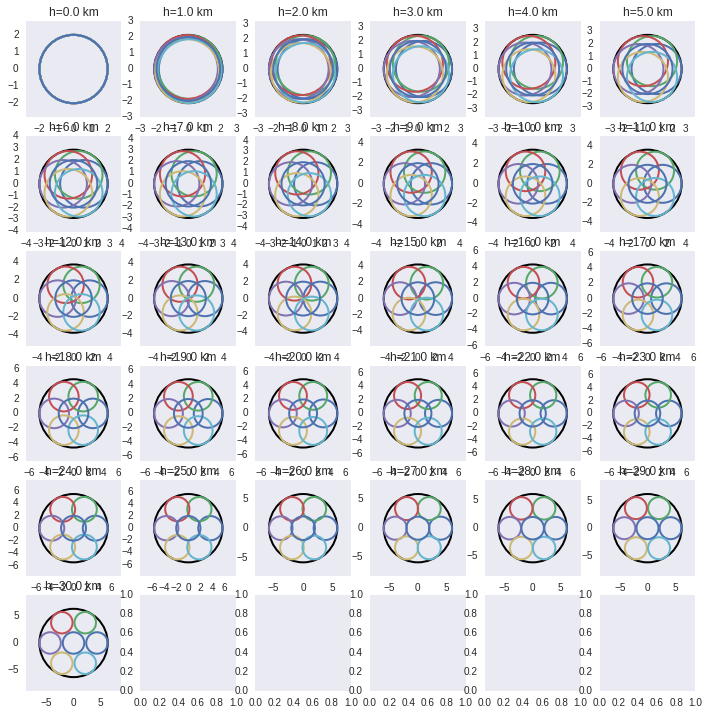

In [5]:
forward.plotPupils()

Let us generate a synthetic observation in which we put turbulent layers at 0, 3, 15 and 25 km and let us try to infer their Zernike coefficients from the observation of 7 reference stars. It is obvious that the least-squares solution will not be successful.

In [31]:
np.random.seed(123)
sns.set_style("dark")
nStars = 7
nZernike = 30
fov = 60.0
r0 = 0.15
DTel = 4.0

heights = np.arange(31)
forward = tomography(nStars, nZernike, fov, heights, DTel)
# forward.generateTurbulentZernikesKolmogorov(r0, keepOnly=[0.0,4.0,16.0])
forward.generateTurbulentZernikesKolmogorov(r0, keepOnly=[0.0, 3.0, 15.0, 25.0])
bMeasured = forward.generateWFS()


heights = np.arange(31)
inversion = tomography(nStars, nZernike, fov, heights, DTel)
inversion.generateTurbulentZernikesKolmogorov(r0)

-------------------------------------------------------------------
 - Zernike modes: 30
 - Number of heights : 31 -> [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.] km
 - FOV: 60.0 arcsec
 - Number of stars : 7
-------------------------------------------------------------------
Projection matrix exists : matrices/transformationMatrices_d5778ba6-ad69-4251-8181-47acb2c30693.npz
 - Zernike modes: 30
 - Number of heights : 31 -> [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.] km
 - FOV: 60.0 arcsec
 - Number of stars : 7
-------------------------------------------------------------------
 - Zernike modes: 30
 - Number of heights : 31 -> [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.

In [35]:
inversion.solveSVD(bMeasured, regularize=True)

In [21]:
inversion.solveFASTA(bMeasured)

FASTA: accelerated(FISTA)+restart - Max. Iter: 60000
It:      0 - resid:   3.7838e+02 - backtrack:  0 - tau:   6.4727e-03
It:    100 - resid:   2.2618e+00 - backtrack:  0 - tau:   6.4727e-03
It:    200 - resid:   4.0002e+00 - backtrack:  0 - tau:   6.4727e-03
It:    300 - resid:   2.1176e-01 - backtrack:  0 - tau:   6.4727e-03
It:    400 - resid:   1.6502e-01 - backtrack:  0 - tau:   6.4727e-03
It:    500 - resid:   1.8572e-01 - backtrack:  0 - tau:   6.4727e-03
It:    600 - resid:   1.4135e-01 - backtrack:  0 - tau:   6.4727e-03
It:    700 - resid:   7.0143e-02 - backtrack:  0 - tau:   6.4727e-03
It:    800 - resid:   4.9277e-02 - backtrack:  0 - tau:   6.4727e-03
It:    900 - resid:   4.8393e-02 - backtrack:  0 - tau:   6.4727e-03
It:   1000 - resid:   9.3439e-02 - backtrack:  0 - tau:   6.4727e-03
It:   1100 - resid:   9.4472e-02 - backtrack:  0 - tau:   6.4727e-03
It:   1200 - resid:   6.2202e-02 - backtrack:  0 - tau:   6.4727e-03
It:   1300 - resid:   3.1222e-02 - backtrack:  0 -

In [32]:
inversion.solveFISTA(bMeasured)

379.479002742
5.73421445021
3.55383046935
3.87155909883
4.29856408775
3.54887297431
3.04104775826
3.26955507946
2.95749692115
2.87225639664
2.06899625177
2.50409427118
2.31619497904
2.51114933776
3.34642247665
2.15567534984
2.08133498259
2.82651132864
1.5737567466
1.80309565397
1.74820208571
1.41927945972
1.3476903439
1.40082624509
1.4788565432
1.77914823592
3.05807041144
2.55059446198
2.40909549581
2.47190306106
2.24987431481
1.99559754084
1.82098770009
2.1552025315
1.49678290824
1.4808678649
1.4576914697
1.47920312386
1.45240311879
1.4946621743
1.55441334145
1.67430089799
1.87426806143
2.68697917973
2.50389166245
2.02465929528
1.83970511116
1.61437206455
1.62981905442
1.5238668875
1.47669626786
1.40154623597
1.43588977837
1.44758307883
1.44536858053
1.43047784624
1.4162235479
1.44545955237
1.44586572173
1.43766236119
1.50070718627
1.58245623122
1.6863116165
1.72182723513
1.78069969806
1.86202793101
1.95737335082
2.12032009403
2.61197641186
2.23881389713
2.44314312113
2.32390729066
2.

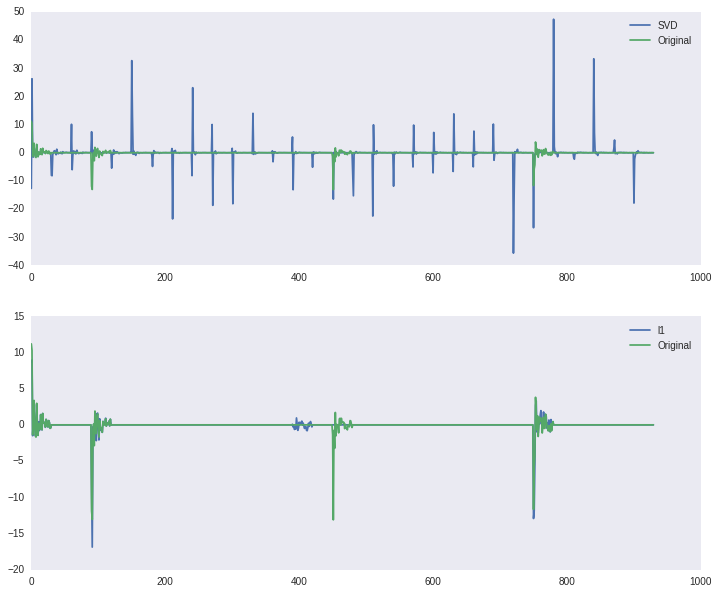

In [36]:
plotResults(forward, inversion)

The previous plot shows the Zernike coefficients for every layer ($31 \times 30$ coefficients), ordered from the lowest layer to the highest. The least-squares solution (SVD) induces the presence of turbulent layers at all heights, while the $\ell_1$ regularized is able to correctly recover all turbulent layers except for the one at 15 km, which is misplaced 2 km below the correct place.